# (L)BFGS

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from distributions import *
from structure import Geometry_tools
import pickle
from optimize import NLLLoss
import tracemalloc
from copy import copy
import time

In [ ]:
from structure import Structure

## 1a02F00

In [3]:
o1a02 = Structure('1a02F00')

In [4]:
s, l, h = o1a02.optimize(100)

Iteration: 000, Loss: 9091.232
Iteration: 001, Loss: 8911.560
Iteration: 002, Loss: 7234.946
Iteration: 003, Loss: 5290.937
Iteration: 004, Loss: 4500.154
Iteration: 005, Loss: 4888.449
Iteration: 006, Loss: 6848.743
Iteration: 007, Loss: 5103.413
Iteration: 008, Loss: 5456.002
Iteration: 009, Loss: 6475.849
Iteration: 010, Loss: 4194.365
Iteration: 011, Loss: 6068.464
Iteration: 012, Loss: 4310.608
Iteration: 013, Loss: 3706.383
Iteration: 014, Loss: 3535.311
Iteration: 015, Loss: 5959.169
Iteration: 016, Loss: 5399.911
Iteration: 017, Loss: 4748.286
Iteration: 018, Loss: 7906.800
Iteration: 019, Loss: 6360.042
Iteration: 020, Loss: 3816.018
Iteration: 021, Loss: 5538.165
Iteration: 022, Loss: 6446.748
Iteration: 023, Loss: 7547.907
Iteration: 024, Loss: 5548.356
Iteration: 025, Loss: 6902.465
Iteration: 026, Loss: 3704.870
Iteration: 027, Loss: 4341.559
Iteration: 028, Loss: 4666.737
Iteration: 029, Loss: 6764.602
Iteration: 030, Loss: 6245.043
Iteration: 031, Loss: 5359.698
Iteratio

KeyboardInterrupt: 

## 16pkA01

In [73]:
structure = Structure('16pkA01')

In [74]:
a = structure.optimize(10)

Iteration: 000, Loss: 50930.543
1962.7619082927704
Iteration: 001, Loss: 43246.809
2005.7403366565704
Iteration: 002, Loss: 40987.164


KeyboardInterrupt: 

---

In [52]:
from structure import *

In [204]:
backbone = torch.tensor([[0, NCA * torch.sin(np.pi - NCAC), 0],  # N
                       [NCA * torch.cos(np.pi - NCAC), 0, 0],          # CA
                       [NCA * torch.cos(np.pi - NCAC) + CAC, 0, 0],    # C
                      ])

N, CA, C = backbone

In [205]:
backbone

tensor([[0.0000, 1.3537, 0.0000],
        [0.5196, 0.0000, 0.0000],
        [2.0396, 0.0000, 0.0000]])

In [206]:
cb = Geometry_tools().place_cbeta(backbone)
cb

tensor([-0.2260, -1.0848, -0.7600])

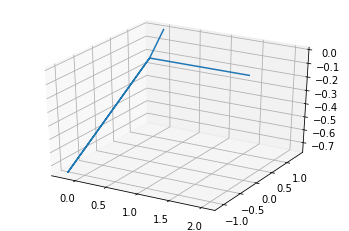

In [192]:
c = torch.cat((N.view(1, 3),
               CA.view(1, 3),
               cb.view(1, 3),
               CA.view(1, 3),
               C.view(1, 3)
              ))

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(c[:, 0], c[:, 1], c[:, 2])

In [211]:
v = C - CA
k = N - CA
k = k / torch.sqrt(torch.sum(k ** 2))

In [212]:
#cb = Geometry_tools().rodrigues(v, k, torch.tensor(np.pi * 7/6)) + backbone[-1]
cb = Geometry_tools().rodrigues(v, k, torch.tensor(np.pi * 4/6)) + CA
cb

tensor([ 0.0524, -0.7628, -1.2289])

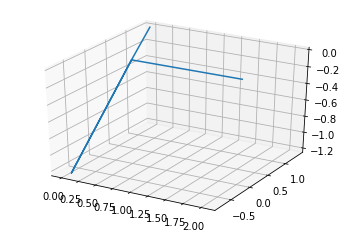

In [213]:
c = torch.cat((N.view(1, 3),
               CA.view(1, 3),
               cb.view(1, 3),
               CA.view(1, 3),
               C.view(1, 3)
              ))

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot(c[:, 0], c[:, 1], c[:, 2])

In [214]:
cb

tensor([ 0.0524, -0.7628, -1.2289])

In [215]:
cacb = cb - CA
can = N - CA
cac = C - CA

cacb_s = torch.sqrt(torch.sum(cacb**2))
can_s = torch.sqrt(torch.sum(can**2))
cac_s = torch.sqrt(torch.sum(cac**2))

In [216]:
can_s

tensor(1.4500)

In [218]:
np.degrees(torch.asin(torch.sum(cac * cacb) / (cac_s * cacb_s)))

tensor(-17.9001)

In [202]:
backbone

tensor([[0.0000, 1.3537, 0.0000],
        [0.5196, 0.0000, 0.0000],
        [2.0396, 0.0000, 0.0000]])

In [203]:
cb

tensor([ 0.0524, -0.7628, -1.2289])

In [149]:
backbone[-2]

tensor([0.5196, 0.0000, 0.0000])